In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sstats
from glob import glob
import numpy as np
from generate_SSRT_cmds import get_completed_subs
import feather
import os
from dask import delayed
import dask.dataframe as dd
import seaborn as sns

In [2]:
subs_w_ssrts = get_completed_subs('ssrt_metrics/individual_metrics')
subs_w_ssrts = list(subs_w_ssrts)

In [78]:
ssrt_metrics = dd.read_csv('ssrt_metrics/individual_metrics/*.csv', include_path_column='filename')
ssrt_metrics['NARGUID'] = ssrt_metrics['filename'].apply(lambda x: x.split('_')[-1].replace('.csv', ''), meta=str)
ssrt_metrics['underlying distribution'] = ssrt_metrics['filename'].apply(lambda x: x.split('/')[-1].split('_')[0], meta=str)
ssrt_metrics['underlying distribution'] = ssrt_metrics['underlying distribution'].map({'graded': 'graded_mu_go_log',
                                                                                       'standard': 'standard',
                                                                                       'guesses': 'guesses'})
ssrt_metrics = ssrt_metrics.drop('filename', axis=1)
ssrt_metrics = ssrt_metrics.rename(columns={'SSRT': 'standard',
                                            'SSRT_w_guesses': 'guesses',
                                            'SSRT_w_graded': 'graded_mu_go_log'})

In [80]:
melt_df = dd.melt(ssrt_metrics, id_vars=['SSD', 'underlying distribution'], value_vars=['standard', 'guesses', 'graded_mu_go_log'], var_name = 'assumed distribution', value_name='SSRT')


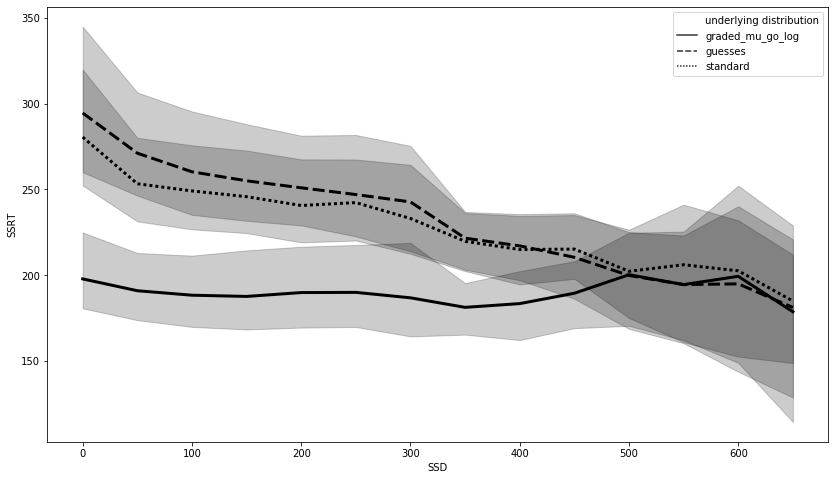

In [81]:
fig,ax = plt.subplots(1,1, figsize=(14, 8))
_ = sns.lineplot(x='SSD', y='SSRT', color='k', style='underlying distribution', data=melt_df[(melt_df['assumed distribution'] == 'standard') & (melt_df['SSD'] <= 650)].compute(), linewidth=3)
plt.savefig('figures/SSRT_by_SSD.png')

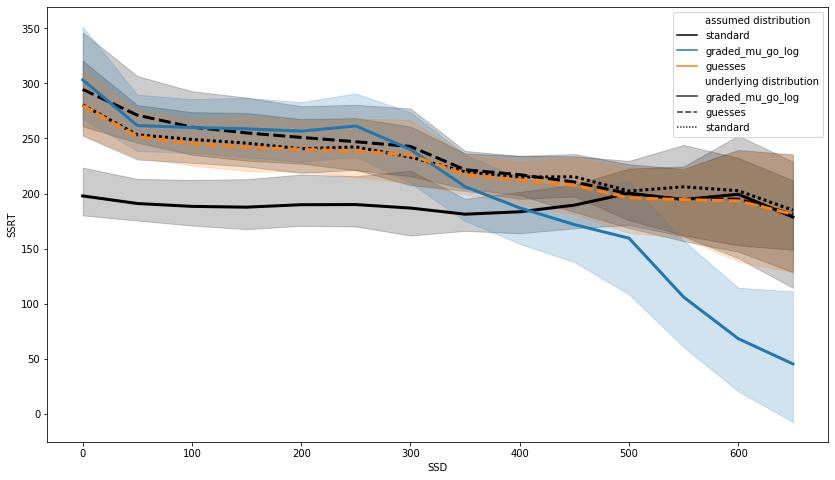

In [83]:
fig,ax = plt.subplots(1,1, figsize=(14, 8))
keep_idx = ((melt_df['assumed distribution'] == 'standard') | (melt_df['assumed distribution'] == melt_df['underlying distribution'])) & (melt_df['SSD'] <= 650)
_ = sns.lineplot(x='SSD', y='SSRT', hue='assumed distribution', style='underlying distribution', data=melt_df[keep_idx].compute(), palette=['k', '#1f77b4', '#ff7f0e'], linewidth=3)
plt.savefig('figures/SSRT_by_SSD_supplement.png')

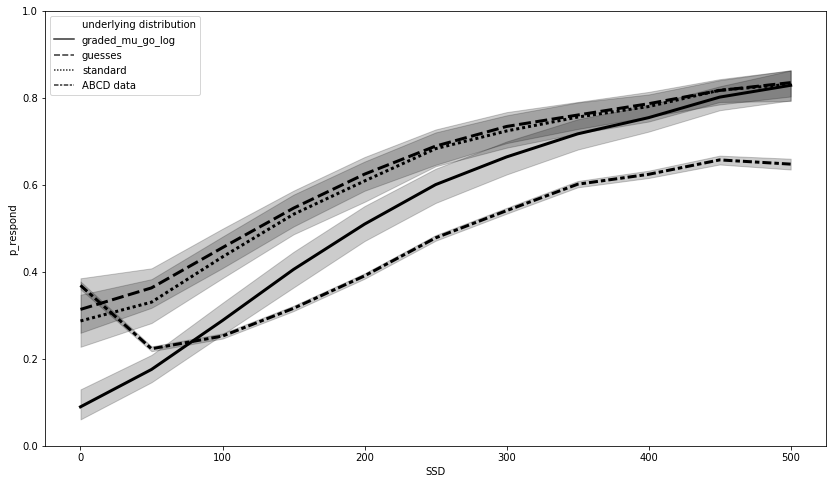

In [84]:
abcd_inhib_func_per_sub = dd.read_csv('abcd_data/abcd_inhib_func_per_sub.csv')
full_inhib_func_df = dd.concat([ssrt_metrics[abcd_inhib_func_per_sub.columns], abcd_inhib_func_per_sub], 0)
fig,ax = plt.subplots(1,1, figsize=(14, 8))
_ = sns.lineplot(x='SSD', y='p_respond', color='k', style='underlying distribution', data=full_inhib_func_df.query('SSD <= 500').compute(), linewidth=3)
_ = plt.ylim([0,1])
plt.savefig('figures/inhibition_function.png')

In [86]:
ssrt_metrics

,Unnamed: 0,standard,mean_SSD,p_respond,max_RT,mean_go_RT,mean_stopfail_RT,omission_count,omission_rate,go_acc,stopfail_acc,SSD,guesses,graded_mu_go_log,NARGUID,underlying distribution
npartitions=84,,,,,,,,,,,,,,,,
,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


# Indvidual Differences

In [29]:
ABCD_SSD_dists = pd.read_csv('abcd_data/SSD_dist_by_subj.csv')

In [100]:
ssrt = np.zeros((1,3))

In [101]:
ssrt += [5, 12, 0]
ssrt

array([[ 5., 12.,  0.]])

In [114]:
def weight_ssrts(sub_df):
    sub_df = sub_df.copy()
    indiv_SSRT = np.zeros((1,3)) # pd.DataFrame([0,0,0], columns=['standard', 'guesses', 'graded_mu_go_log'])
    sub = sub_df['NARGUID'].unique()[0]
    sub_dists = ABCD_SSD_dists.query("NARGUID=='%s'" % sub)
#     gen_str = sub_df['underlying distribution'].unique()[0]
    for SSD in sub_dists.SSDDur:
        ssd_SSRTs = sub_df.loc[sub_df.SSD==SSD, ['standard', 'guesses', 'graded_mu_go_log']].values[0]
        weight = sub_dists.loc[sub_dists.SSDDur==SSD, 'proportion'].values
        indiv_SSRT += ssd_SSRTs * weight
    return pd.DataFrame(indiv_SSRT, columns=['standard', 'guesses', 'graded_mu_go_log'])

In [115]:
expected_ssrts = ssrt_metrics.groupby(['NARGUID', 'underlying distribution']).apply(lambda x: weight_ssrts(x))

/Users/henrymj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


In [117]:
expected_ssrts = expected_ssrts.compute()

In [119]:
expected_ssrts = expected_ssrts.reset_index()

In [127]:
expected_ssrts

,NARGUID,underlying distribution,level_2,standard,guesses,graded_mu_go_log
0,0GUTM6AM,standard,0,260.583333,268.037934,463.416667
1,0FBX6KWX,graded_mu_go_log,0,206.433333,201.013584,320.300000
2,0L1GB53L,guesses,0,300.450000,275.595241,308.166667
3,0T7889MV,guesses,0,219.050000,209.830066,278.900000
4,0TJZ2RA3,guesses,0,298.700000,283.553923,415.400000
...,...,...,...,...,...,...
79,06WHVUPX,guesses,0,206.416667,209.952626,351.150000
80,08R2PTT1,standard,0,279.433333,289.172596,522.850000
81,0B7UGM1D,graded_mu_go_log,0,187.600000,176.758299,214.850000
82,042UJKFB,graded_mu_go_log,0,156.383333,151.818265,208.933333


In [122]:
pivot_ssrts = expected_ssrts.pivot(index='NARGUID', columns='underlying distribution', values=['standard', 'guesses', 'graded_mu_go_log'])

In [125]:
pivot_ssrts.corr(method='spearman')

standard                      \
underlying distribution                  graded_mu_go_log   guesses  standard   
                 underlying distribution                                        
standard         graded_mu_go_log                1.000000  0.844007  0.829776   
                 guesses                         0.844007  1.000000  0.946907   
                 standard                        0.829776  0.946907  1.000000   
guesses          graded_mu_go_log                0.979748  0.848385  0.856048   
                 guesses                         0.799124  0.969896  0.961686   
                 standard                        0.709360  0.889436  0.960044   
graded_mu_go_log graded_mu_go_log                0.413246  0.706623  0.773946   
                 guesses                         0.411056  0.710454  0.774494   
                 standard                        0.364532  0.668856  0.741653   

                                                  guesses                      \
underlying distribution                  graded_mu_go_log   guesses  standard   
                 underlying distribution                                        
standard         graded_mu_go_log                0.979748  0.799124  0.709360   
                 guesses                         0.848385  0.969896  0.889436   
                 standard                        0.856048  0.961686  0.960044   
guesses          graded_mu_go_log                1.000000  0.836891  0.770662   
                 guesses                         0.836891  1.000000  0.955665   
                 standard                        0.770662  0.955665  1.000000   
graded_mu_go_log graded_mu_go_log                0.493158  0.796935  0.882868   
                 guesses                         0.489874  0.800219  0.884510   
                 standard                        0.446634  0.767378  0.865900   

                                         graded_mu_go_log                      
underlying distribution                  graded_mu_go_log   guesses  standard  
                 underlying distribution                                       
standard         graded_mu_go_log                0.413246  0.411056  0.364532  
                 guesses                         0.706623  0.710454  0.668856  
                 standard                        0.773946  0.774494  0.741653  
guesses          graded_mu_go_log                0.493158  0.489874  0.446634  
                 guesses                         0.796935  0.800219  0.767378  
                 standard                        0.882868  0.884510  0.865900  
graded_mu_go_log graded_mu_go_log                1.000000  0.995621  0.992337  
                 guesses                         0.995621  1.000000  0.996169  
                 standard                        0.992337  0.996169  1.000000